In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
cd \

C:\


In [3]:
cd Penn State\Projects\Lane Detection\Dataset

C:\Penn State\Projects\Lane Detection\Dataset


In [4]:
import os
os.getcwd()

'C:\\Penn State\\Projects\\Lane Detection\\Dataset'

In [5]:
import pandas as pd
import numpy as np
import keras
import h5py
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
from keras.preprocessing import image
from keras.layers.core import Dropout, Lambda
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Add, Flatten, UpSampling2D, BatchNormalization
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input
from keras.optimizers import Adam, Adadelta
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU
#from keras.layers.convolutional import Deconvolution2D

Using TensorFlow backend.


# Import data from system to numpy array

In [6]:
%%time

train = []

for file in os.listdir(os.path.join(os.getcwd(), 'RGB_data')):
    train.append([os.path.join(os.getcwd(), 'RGB_data', file),
                     os.path.join(os.getcwd(), 'Segmented_data', file)])
train = pd.DataFrame(train, columns=['Camera_Image', 'Segmented_Images'])

Augmented_data = []

for file in os.listdir(os.path.join(os.getcwd(), 'Augmented_RGB')):
    Augmented_data.append([os.path.join(os.getcwd(), 'Augmented_RGB', file),
                     os.path.join(os.getcwd(), 'Augmented_Seg', file)])
    
Augmented_data = pd.DataFrame(Augmented_data, columns=['Camera_Image', 'Segmented_Images'])

Train_data = [train, Augmented_data]
Train_data = pd.concat(Train_data)
Train_data = Train_data.sample(frac=1).reset_index(drop=True)

x_train = []
y_train= []

for i in range(len(Train_data)):
    img = cv2.imread(Train_data.iloc[i][0])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    x_train.append(img)
    img = cv2.imread(Train_data.iloc[i][1])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    y_train.append(img)
    if i%999 == 0:
        print(i," images are done")
    
x_train = np.array(x_train) #Camera RGB data
y_train = np.array(y_train) #Segmented data

0  images are done
999  images are done
1998  images are done
2997  images are done
Wall time: 42.2 s


In [7]:
del train
del Augmented_data
del Train_data

# Train image

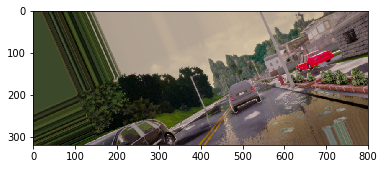

In [8]:
plt.imshow(x_train[299])

# Segmented Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


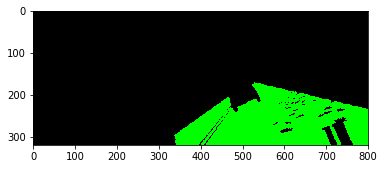

In [9]:
import math
def encoded_to_colored(image):
    x_visual= np.zeros((320, 800, 3), dtype = float)
    #image = skyHoodRemove(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if math.floor(max(image[i][j] )) == 1:
                x_visual[i][j] = [0.,0.,0.]
            else :
                x_visual[i][j] = [0., 255., 0.]
                
    
    return x_visual
plt.imshow(encoded_to_colored(y_train[299]))

# Split data into train and test set

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.1, random_state=125)

In [11]:
print('Shape of Training data: ', x_train.shape, '  Shape of Training label: ', y_train.shape)

Shape of Training data:  (2700, 320, 800, 3)   Shape of Training label:  (2700, 320, 800, 3)


In [12]:
print('Shape of Test data: ', x_test.shape, '  Shape of Test label: ', y_test.shape)

Shape of Test data:  (300, 320, 800, 3)   Shape of Test label:  (300, 320, 800, 3)


# Metric

In [13]:
from keras import backend as K
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

"""

def mean_iou(y_true, y_pred):
    y_pred_ = tf.to_int32(y_pred > 0.75)
    score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
    K.get_session().run(tf.local_variables_initializer())
    with tf.control_dependencies([up_opt]):
        score = tf.identity(score)
    return score"""

'\n\ndef mean_iou(y_true, y_pred):\n    y_pred_ = tf.to_int32(y_pred > 0.75)\n    score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)\n    K.get_session().run(tf.local_variables_initializer())\n    with tf.control_dependencies([up_opt]):\n        score = tf.identity(score)\n    return score'

# Build the Model

In [14]:
image_input=Input(shape=(320, 800, 3))

In [24]:
from keras.layers import *


def Astrous_Conv(inp, d1, d2, d3):
    x1 = Conv2D(10, (1,1), padding = 'same')(inp)
    x2 = Conv2D(10, (3,3), padding = 'same', dilation_rate=(d1, d1))(inp)
    x3 = Conv2D(10, (3,3), padding = 'same', dilation_rate=(d2, d2))(inp)
    x4 = Conv2D(10, (3,3), padding = 'same', dilation_rate=(d3, d3))(inp)
    return Concatenate()([x1, x2, x3, x4, inp])
    

"""
def Conv_Pooling_block(inp, f1, f2):
    x = Conv2D(f1, (3,3), padding = 'same')(inp)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Conv2D(f2, (3,3), padding = 'same', activation= 'relu')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    return x
"""

def Conv_block(inp,f1):
    x = Conv2D(f1, (3,3), padding = 'same')(inp)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Conv2D(f1, (3,3), padding = 'same')(inp)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    #Residual Connection
    inp = Conv2D(f1, (1,1), padding = 'same')(inp)
    x = Add()([x, inp])
    x = LeakyReLU(alpha=0.3)(x)
    return x

def Conv_Pooling_block(inp, f1, f2):
    x = Conv2D(f1, (2,2), padding = 'same')(inp)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Conv2D(f2, (2,2), strides = 2, padding = 'valid')(x)
    #Residual Connection
    inp = Conv2D(f2, (1,1), strides = 2, padding = 'valid')(inp)
    x = Add()([x, inp])
    x = LeakyReLU(alpha=0.3)(x)
    return x



#Input
ip = Input(shape=(320, 800, 3))


################### Entry Flow #######################################
#Conv Block1
x = Conv_Pooling_block(ip, 4, 10)
#print(x1)

#Conv Layer2
x_FD = Conv_Pooling_block(x, 8, 15) #Save this layer output for feedforward connection
#print(x2)

#Conv Layer3
x = Conv_Pooling_block(x_FD, 16, 20)
#print(x3)



############ Middle Flow ###############
for i in range(16):
    x = Conv_block(x,20)

###################################################




############ End FLow ################
#Conv Layer4
x = Conv_Pooling_block(x, 32, 32)
#print(x4)

 
#Astrous Convolution with dilation rates 2,3,5
x = Astrous_Conv(x, 2, 3, 5)
#x = Astrous_Conv(x, 2, 3, 5)
#x = Astrous_Conv(x, 2, 3, 5)
#x = Astrous_Conv(x, 2, 3, 5)


#Change the number of filters after concatenation
x = Conv2D(15, (1,1), padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)





############################### Upsampling #########################
#Upsampling by factor of 4
x = UpSampling2D(size=(4, 4), data_format=None, interpolation='bilinear')(x)


#Concatenating this with low level features from x_FD
x_FD = Conv2D(15, (1,1), padding = 'same')(x_FD)
x = Concatenate()([x, x_FD])


#Convolution to get 3 channels
x = Conv2D(3, (3,3), padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)

#Upsampling by factor of 4
x = UpSampling2D(size=(4, 4), data_format=None, interpolation='bilinear')(x)

#Sigmoid activation
x = Conv2D(3, (1, 1), activation='sigmoid') (x)

model_new = Model(ip, x)
model_new.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 320, 800, 3)  0                                            
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 320, 800, 4)  52          input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 320, 800, 4)  16          conv2d_97[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_55 (LeakyReLU)      (None, 320, 800, 4)  0           batch_normalization_42[0][0]     
__________________________________________________________________________________________________
conv2d_98 

In [25]:
from keras.metrics import categorical_accuracy
from keras import optimizers

# Compile and train the model

In [26]:
model_new.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['binary_accuracy',mean_iou])
earlystopper = EarlyStopping(monitor='val_mean_iou', min_delta=0.005, patience=0, verbose=1, mode = 'max')
checkpoint =ModelCheckpoint(filepath='Lane_Model_ DeepLab -Version1/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
    monitor='val_mean_iou',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    period=3)

In [27]:
history = model_new.fit(x_train, y_train, epochs=100, batch_size=20, validation_split=0.1, callbacks=[earlystopper, checkpoint], 
                        shuffle=False)

Train on 2430 samples, validate on 270 samples
Epoch 1/100
2430/2430 [==============================] - 157s 65ms/step - loss: 0.5142 - binary_accuracy: 0.7888 - mean_iou: 0.2560 - val_loss: 0.5084 - val_binary_accuracy: 0.7981 - val_mean_iou: 0.3104
Epoch 2/100
2430/2430 [==============================] - 152s 63ms/step - loss: 0.3437 - binary_accuracy: 0.9039 - mean_iou: 0.3518 - val_loss: 0.3466 - val_binary_accuracy: 0.9198 - val_mean_iou: 0.3961
Epoch 3/100
2430/2430 [==============================] - 152s 63ms/step - loss: 0.2374 - binary_accuracy: 0.9703 - mean_iou: 0.4352 - val_loss: 0.2521 - val_binary_accuracy: 0.9555 - val_mean_iou: 0.4727

Epoch 00003: val_mean_iou improved from -inf to 0.47266, saving model to Lane_Model_ DeepLab -Version1/weights.03-0.25.hdf5
Epoch 4/100
2430/2430 [==============================] - 153s 63ms/step - loss: 0.1650 - binary_accuracy: 0.9796 - mean_iou: 0.5051 - val_loss: 0.1619 - val_binary_accuracy: 0.9751 - val_mean_iou: 0.5354
Epoch 5/100


In [28]:
model_new.save('Lane_Model_ DeepLab -Version1.h5')

# Test set analysis

In [30]:
y_pred = model_new.predict(x_test, batch_size=16, verbose=2, steps=None)

In [31]:
test_eval = model_new.evaluate(x_test, y_test, batch_size=20, verbose=1, sample_weight=None)

300/300 [==============================] - 16s 55ms/step


In [33]:
print('Test set mIOU: ',test_eval[2])

Test set mIOU:  0.8456660509109497


# Visualizations of test set images

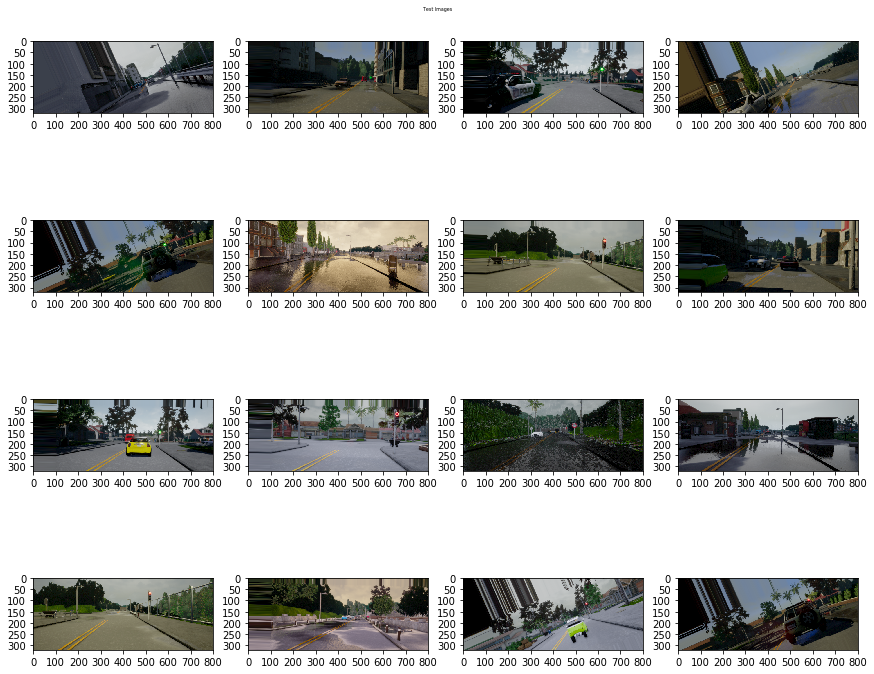

In [35]:
from random import randint

x = [randint(0, len(x_test)) for p in range(16)]
f, axs = plt.subplots(4,4, figsize=(12,10), )
plt.rcParams.update({'font.size': 4})
f.tight_layout()
f.suptitle('Test Images')
for i, ax in enumerate(axs.ravel()):
    ax.grid('off')
    ax.imshow(x_test[i])

# Corresponding Model generated segmented images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

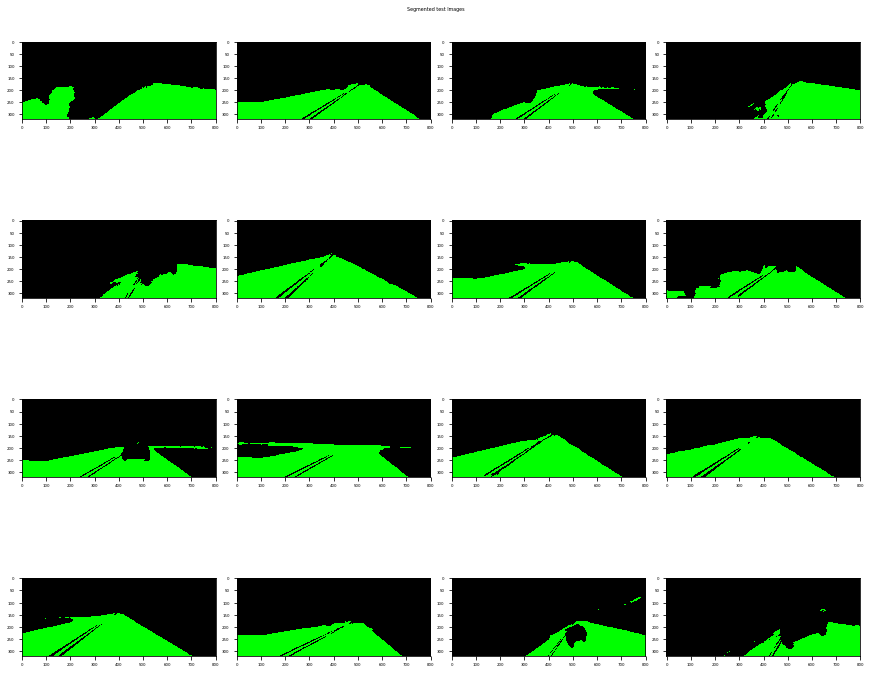

In [37]:
f, axs = plt.subplots(4,4, figsize=(12,10))
plt.rcParams.update({'font.size': 4})
f.tight_layout()
f.suptitle('Segmented test Images')
for i, ax in enumerate(axs.ravel()):
    ax.grid('off')
    
    ax.imshow(encoded_to_colored(y_pred[i]>0.35))

# Model generated image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


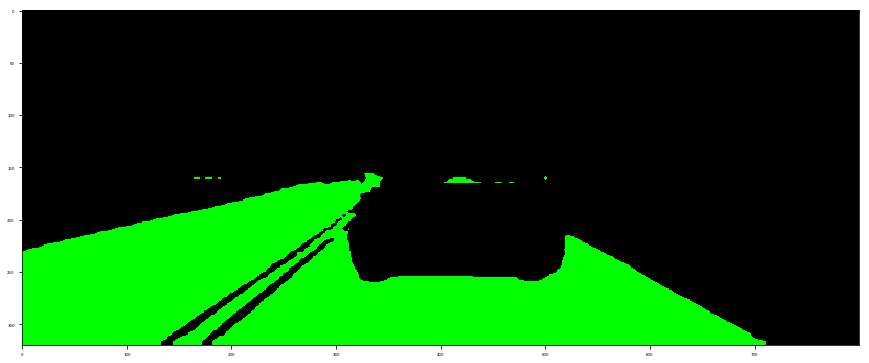

In [38]:
plt.imshow(encoded_to_colored(y_pred[288] > 0.35))


# Corresponding label image 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


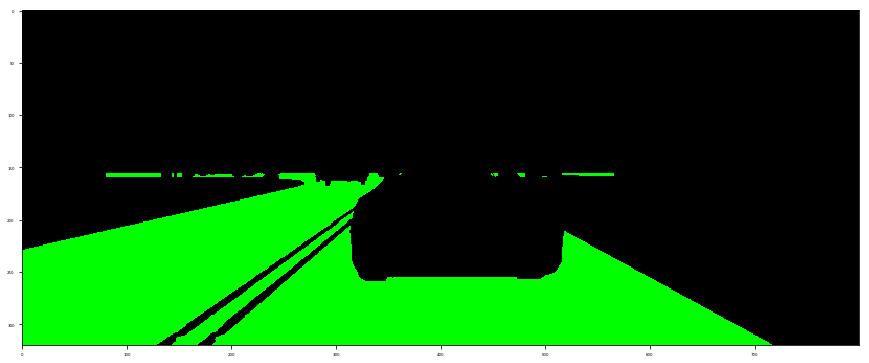

In [39]:
plt.imshow(encoded_to_colored(y_test[288]))